<a href="https://colab.research.google.com/github/SzymonNowakowski/diffusions/blob/master/rr_compute.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# rr function

### Author: Piotr Pokarowski (R code) and Szymon Nowakowski (Python port and tests)



In [19]:
import torch
dtype=torch.float32

noise = torch.tensor([0.0000000], dtype=dtype, device="cpu")
torch.set_printoptions(precision=7, sci_mode=False)


def rr(num_steps: int, res_dtype: torch.dtype, device: torch.device):
    """
    Implementation of the R logic in PyTorch.
    Returns:
        rrFLOW, rrMSE, rrML, betaFLOW, betaMSE, betaML
    Each vector has length num_steps, sorted from largest to smallest,
    with 0.0 appended at the end.
    """
    num_steps = int(num_steps)
    dtype = torch.float64

    # s1 = seq(0.002^(1/7), 80^(1/7), len=TT)^7
    start = 0.002 ** (1.0 / 7.0)
    end = 80.0 ** (1.0 / 7.0)
    s1_root = torch.linspace(start, end, num_steps, dtype=dtype, device=device)
    s1 = s1_root ** 7.0

    # roO = 1/s1
    ro0 = 1.0 / s1

    # R:
    #   roO[-TT] = all except the last one  -> ro0[:-1]
    #   roO[-1]  = all except the first one -> ro0[1:]
    ro0_head = ro0[:-1]  # roO[-TT]
    ro0_tail = ro0[1:]   # roO[-1]

    # gaO = (roO[-TT]/roO[-1])^2
    ga0 = (ro0_head / ro0_tail) ** 2.0  # (ro_new / ro_old)^2

    # fpred = sqrt(1+4/roO[-1]^2)
    fpred = torch.sqrt(1.0 + 4.0 / (ro0_tail ** 2.0))

    # fpred = fpred*max(sqrt((gaO-1)/2)/fpred) +1e-10
    scale = torch.max(torch.sqrt((ga0 - 1.0) / 2.0) / fpred)
    fpred = fpred * scale + 1e-10

    # eta2 = (gaO-1)^2 / (fpred*sqrt(2*gaO) + sqrt(2*fpred^2+1-gaO))^2
    numer = (ga0 - 1.0) ** 2.0
    denom = fpred * torch.sqrt(2.0 * ga0) + torch.sqrt(2.0 * fpred ** 2.0 + 1.0 - ga0)
    eta2 = numer / (denom ** 2.0)  # eta^2

    # ga = 1/(1 - eta2)
    ga = 1.0 / (1.0 - eta2)  # (ro_new / ro_old)^2

    # rrFLOW = 1/sqrt(gaO)     # r_old / r_new
    rrFLOW = 1.0 / torch.sqrt(ga0)

    # rrMSE = 1/sqrt(ga*gaO)   # r_old / r_new
    rrMSE = 1.0 / torch.sqrt(ga * ga0)

    # rrML = 1/gaO             # r_old / r_new
    rrML = 1.0 / ga0

    # betaMSE = sqrt(eta2)/roO[-TT]
    betaMSE = torch.sqrt(eta2) / ro0_head

    # betaML = sqrt(1 - 1/gaO)/roO[-TT]
    betaML = torch.sqrt(1.0 - 1.0 / ga0) / ro0_head

    # --- NEW STEP: reverse vectors so they are sorted from largest to smallest ---
    rrFLOW = torch.flip(rrFLOW, dims=[0])
    rrMSE  = torch.flip(rrMSE,  dims=[0])
    rrML   = torch.flip(rrML,   dims=[0])

    betaMSE = torch.flip(betaMSE, dims=[0])
    betaML  = torch.flip(betaML,  dims=[0])

    # FLOW: all zeros (same length as betaMSE/betaML before appending zero)
    betaFLOW = torch.zeros_like(betaMSE)

    # append 0.0 at the end so the vector has length num_steps
    zero = torch.zeros(1, dtype=dtype, device=device)

    rrFLOW   = torch.cat([rrFLOW,   zero], dim=0).to(dtype = res_dtype)
    rrMSE    = torch.cat([rrMSE,    zero], dim=0).to(dtype = res_dtype)
    rrML     = torch.cat([rrML,     zero], dim=0).to(dtype = res_dtype)
    betaFLOW = torch.cat([betaFLOW, zero], dim=0).to(dtype = res_dtype)
    betaMSE  = torch.cat([betaMSE,  zero], dim=0).to(dtype = res_dtype)
    betaML   = torch.cat([betaML,   zero], dim=0).to(dtype = res_dtype)

    return rrFLOW, rrMSE, rrML, betaFLOW, betaMSE, betaML





In [20]:
r_vals_FLOW = torch.tensor([  #rrFLOW by Pokar - sigma ratios
        0.8366359, 0.8327429, 0.8286604, 0.8243743, 0.8198691,
        0.8151275, 0.8101306, 0.8048572, 0.7992839, 0.7933844,
        0.7871296, 0.7804864, 0.7734178, 0.7658819, 0.7578312,
        0.7492115, 0.7399610, 0.7300084, 0.7192719, 0.7076561,
        0.6950504, 0.6813246, 0.6663258, 0.6498723, 0.6317477,
        0.6116921, 0.5893917, 0.5644651, 0.5364472, 0.5047683,
        0.4687320, 0.0000000
    ], dtype=dtype, device=noise.device)

betas_diffusion_FLOW = torch.tensor([
  0.0000000, 0.0000000, 0.0000000, 0.0000000, 0.0000000,
  0.0000000, 0.0000000, 0.0000000, 0.0000000, 0.0000000,
  0.0000000, 0.0000000, 0.0000000, 0.0000000, 0.0000000,
  0.0000000, 0.0000000, 0.0000000, 0.0000000, 0.0000000,
  0.0000000, 0.0000000, 0.0000000, 0.0000000, 0.0000000,
  0.0000000, 0.0000000, 0.0000000, 0.0000000, 0.0000000,
  0.0000000, 0.0000000
], dtype=dtype, device=noise.device)

r_vals_MSE = torch.tensor([  #rrMSE by Pokar
  0.8366357, 0.8327426, 0.8286600, 0.8243737, 0.8198681,
  0.8151260, 0.8101281, 0.8048533, 0.7992774, 0.7933737,
  0.7871113, 0.7804548, 0.7733622, 0.7657820, 0.7576482,
  0.7488696, 0.7393110, 0.7287571, 0.7168593, 0.7030898,
  0.6868220, 0.6676873, 0.6459559, 0.6222139, 0.5965456,
  0.5682467, 0.5359994, 0.4978241, 0.4503007, 0.3852130,
  0.2197134, 0.0000000
], dtype=dtype, device=noise.device)

betas_diffusion_MSE = torch.tensor([
  0.043344183, 0.044376738, 0.045459380, 0.046595754, 0.047789821,
  0.049045871, 0.050368504, 0.051762576, 0.053233054, 0.054784720,
  0.056421549, 0.058145500, 0.059954137, 0.061835954, 0.063761203,
  0.065663974, 0.067407924, 0.068724701, 0.069120044, 0.067790560,
  0.063734535, 0.056347248, 0.046276620, 0.035376323, 0.025486142,
  0.017531299, 0.011610107, 0.007427481, 0.004594182, 0.002757327,
  0.001766672, 0.000000000
], dtype=dtype, device=noise.device)

r_vals_MSE_63 = torch.tensor([  # rrMSE by Pokar
  0.915197, 0.9141584, 0.9130933, 0.9120015, 0.9108819,
  0.9097335, 0.9085551, 0.9073455, 0.9061035, 0.9048278,

  0.9035169, 0.9021693, 0.9007836, 0.8993580, 0.8978907,
  0.8963800, 0.8948237, 0.8932197, 0.8915658, 0.8898594,

  0.8880979, 0.8862783, 0.8843976, 0.8824521, 0.8804380,
  0.8783509, 0.8761857, 0.8739365, 0.8715964, 0.8691570,

  0.8666081, 0.8639367, 0.8611263, 0.8581559, 0.8549980,
  0.8516176, 0.8479704, 0.8440028, 0.8396537, 0.8348607,

  0.8295707, 0.8237538, 0.8174154, 0.8105968, 0.8033628,
  0.7957759, 0.7878728, 0.7796501, 0.7710623, 0.7620285,

  0.7524396, 0.7421621, 0.7310375, 0.7188746, 0.7054347,
  0.6904060, 0.6733564, 0.6536437, 0.6302156, 0.6010721,

  0.5611755, 0.4592289, 0.0000000
], dtype=dtype, device=noise.device)

betas_diffusion_MSE_63 = torch.tensor([
  0.039073243, 0.039551953, 0.040042504, 0.040545336, 0.041060907,
  0.041589700, 0.042132218, 0.042688988, 0.043260559, 0.043847507,

  0.044450430, 0.045069949, 0.045706711, 0.046361379, 0.047034633,
  0.047727167, 0.048439675, 0.049172840, 0.049927320, 0.050703719,

  0.051502552, 0.052324197, 0.053168821, 0.054036279, 0.054925978,
  0.055836674, 0.056766194, 0.057711046, 0.058665866, 0.059622650,

  0.060569693, 0.061490129, 0.062359987, 0.063145664, 0.063800839,
  0.064263066, 0.064450726, 0.064261832, 0.063577149, 0.062270922,

  0.060231804, 0.057392975, 0.053763558, 0.049447122, 0.044634229,
  0.039567833, 0.034495387, 0.029627320, 0.025114529, 0.021045563,

  0.017456520, 0.014345626, 0.011687116, 0.009442081, 0.007565980,
  0.006013398, 0.004740838, 0.003708284, 0.002880117, 0.002226155,

  0.001725404, 0.001470735, 0.000000000
], dtype=dtype, device=noise.device)

r_vals_ML = torch.tensor([  #rrML by Pokar - sigma ratios squared
  0.6999597, 0.6934608, 0.6866781, 0.6795930, 0.6721853,
  0.6644328, 0.6563115, 0.6477951, 0.6388547, 0.6294589,
  0.6195730, 0.6091590, 0.5981751, 0.5865751, 0.5743081,
  0.5613179, 0.5475422, 0.5329123, 0.5173520, 0.5007772,
  0.4830950, 0.4642033, 0.4439901, 0.4223341, 0.3991052,
  0.3741673, 0.3473825, 0.3186209, 0.2877756, 0.2547910,
  0.2197097, 0.0000000
], dtype=dtype, device=noise.device)

betas_diffusion_ML = torch.tensor([
  36.662013635, 30.858902915, 25.852908864, 21.552093680, 17.872989770,
  14.740026867, 12.084983057, 9.846459379, 7.969377645, 6.404501137,
  5.107977807, 4.040905633, 3.168919747, 2.461800968, 1.893105349,
  1.439814351, 1.082005249, 0.802541356, 0.586781653, 0.422309410,
  0.298679353, 0.207182933, 0.140631255, 0.093155182, 0.060022151,
  0.037469196, 0.022551663, 0.013007109, 0.007133814, 0.003683362,
  0.001766681, 0.000000000
], dtype=dtype, device=noise.device)

r_vals_ML_63 = torch.tensor([  # rrML by Pokar
  0.8375871, 0.8356859, 0.8337398, 0.8317472, 0.8297064,
  0.8276157, 0.8254732, 0.8232769, 0.8210249, 0.8187149,

  0.8163448, 0.8139120, 0.8114143, 0.8088489, 0.8062130,
  0.8035037, 0.8007179, 0.7978524, 0.7949037, 0.7918681,

  0.7887418, 0.7855207, 0.7822003, 0.7787762, 0.7752433,
  0.7715965, 0.7678302, 0.7639385, 0.7599150, 0.7557531,

  0.7514454, 0.7469843, 0.7423615, 0.7375682, 0.7325948,
  0.7274312, 0.7220663, 0.7164883, 0.7106844, 0.7046408,

  0.6983426, 0.6917737, 0.6849164, 0.6777517, 0.6702590,
  0.6624157, 0.6541970, 0.6455762, 0.6365238, 0.6270075,

  0.6169919, 0.6064379, 0.5953028, 0.5835392, 0.5710949,
  0.5579123, 0.5439274, 0.5290698, 0.5132614, 0.4964158,

  0.4784378, 0.4592230, 0.0000000
], dtype=dtype, device=noise.device)

betas_diffusion_ML_63 = torch.tensor([
  29.506336512, 27.130884030, 24.919304383, 22.862229095, 20.950711687,
  19.176213924, 17.530592329, 16.006084966, 14.595298502, 13.291195523,

  12.087082127, 10.976595773, 9.953693395, 9.012639773, 8.147996166,
  7.354609196, 6.627599987, 5.962353561, 5.354508476, 4.799946715,

  4.294783827, 3.835359299, 3.418227182, 3.040146953, 2.698074608,
  2.389154001, 2.110708411, 1.860232339, 1.635383539, 1.433975272,

  1.253968783, 1.093466009, 0.950702499, 0.824040553, 0.711962584,
  0.613064683, 0.526050405, 0.449724754, 0.382988384, 0.324831999,

  0.274330953, 0.230640051, 0.192988549, 0.160675344, 0.133064358,
  0.109580108, 0.089703466, 0.072967598, 0.058954091, 0.047289246,

  0.037640559, 0.029713366, 0.023247663, 0.018015084, 0.013816053,
  0.010477088, 0.007848268, 0.005800850, 0.004225037, 0.003027900,

  0.002131431, 0.001470751, 0.000000000
], dtype=dtype, device=noise.device)

# --- execute rr function ---
rrFLOW, rrMSE, rrML, betaFLOW, betaMSE, betaML = rr(32, dtype, noise.device)

# --- comparison FLOW ---

assert torch.allclose(rrFLOW, r_vals_FLOW, atol=1e-6), "FLOW rr mismatch"
assert torch.allclose(betaFLOW, betas_diffusion_FLOW, atol=1e-6), "FLOW beta mismatch"

# --- comparison MSE ---
assert torch.allclose(rrMSE, r_vals_MSE, atol=1e-6), "MSE rr mismatch"
assert torch.allclose(betaMSE, betas_diffusion_MSE, atol=1e-6), "MSE beta mismatch"

# --- comparison ML ---
assert torch.allclose(rrML, r_vals_ML, atol=1e-6), "ML rr mismatch"
assert torch.allclose(betaML, betas_diffusion_ML, atol=1e-6), "ML beta mismatch"

# --- execute rr function ---
rrFLOW_63, rrMSE_63, rrML_63, betaFLOW_63, betaMSE_63, betaML_63 = rr(63, dtype, noise.device)

# --- MSE ---
assert torch.allclose(rrMSE_63, r_vals_MSE_63, atol=1e-6), "MSE-63 rr mismatch"
assert torch.allclose(betaMSE_63, betas_diffusion_MSE_63, atol=1e-6), "MSE-63 beta mismatch"

# --- ML ---
assert torch.allclose(rrML_63, r_vals_ML_63, atol=1e-6), "ML-63 rr mismatch"
assert torch.allclose(betaML_63, betas_diffusion_ML_63, atol=1e-6), "ML-63 beta mismatch"

print(rr(128, dtype, noise.device))


(tensor([0.9577957, 0.9575397, 0.9572807, 0.9570184, 0.9567529, 0.9564841,
        0.9562119, 0.9559364, 0.9556572, 0.9553746, 0.9550884, 0.9547984,
        0.9545047, 0.9542071, 0.9539056, 0.9536001, 0.9532906, 0.9529769,
        0.9526589, 0.9523366, 0.9520099, 0.9516787, 0.9513429, 0.9510024,
        0.9506571, 0.9503068, 0.9499516, 0.9495913, 0.9492257, 0.9488549,
        0.9484785, 0.9480966, 0.9477089, 0.9473155, 0.9469160, 0.9465105,
        0.9460987, 0.9456806, 0.9452558, 0.9448245, 0.9443862, 0.9439409,
        0.9434885, 0.9430287, 0.9425613, 0.9420863, 0.9416032, 0.9411122,
        0.9406127, 0.9401047, 0.9395880, 0.9390622, 0.9385272, 0.9379828,
        0.9374287, 0.9368645, 0.9362900, 0.9357051, 0.9351093, 0.9345024,
        0.9338840, 0.9332538, 0.9326115, 0.9319566, 0.9312890, 0.9306082,
        0.9299137, 0.9292052, 0.9284822, 0.9277443, 0.9269910, 0.9262219,
        0.9254364, 0.9246340, 0.9238142, 0.9229763, 0.9221198, 0.9212441,
        0.9203484, 0.9194322, 0.91849

# Sine/Cosine Variance Preserving Interpolator

$$
\alpha(t) = \cos\left( \frac{\pi}{2} \frac{t}{T} \right)
$$

$$
\sigma(t) = \sin\left( \frac{\pi}{2} \frac{t}{T} \right)
$$

$$
\alpha^2(t) + \sigma^2(t) = 1
$$

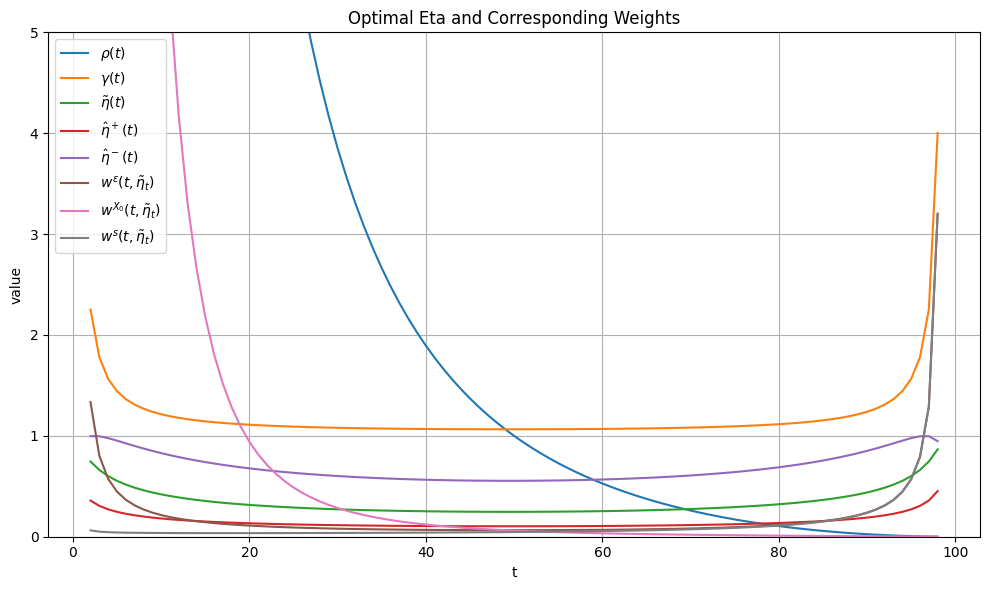

In [ ]:
T = 100
next_ind = lambda t: t+1
prev_ind = lambda t: t-1
alpha = lambda t: np.cos(t/T * np.pi / 2)
sigma = lambda t: np.sin(t/T * np.pi / 2)

rho = lambda t: (alpha(t)/sigma(t)) ** 2
gamma = lambda t: rho(t)/rho(next_ind(t))

eta_optim = lambda t: (1-1/gamma(t)) ** 0.5
weight_optim = lambda t: gamma(t) - 1
weight_epsilon = lambda t, eta: rho(t)/eta**2 * (1/rho(t)**0.5 * (1-eta**2)**0.5- 1/rho(next_ind(t))**0.5 )**2

weight_X0 = lambda t, eta: weight_epsilon(t, eta) * rho(next_ind(t))
weight_s = lambda t, eta: weight_epsilon(t, eta) * sigma(next_ind(t))

eta_twice_plus = lambda t: np.sqrt(1 - (
    (np.sqrt(gamma(t)) + np.sqrt(gamma(t) - (2 * gamma(t) - 1) * (2 - gamma(t)))) / (2 * gamma(t) - 1)
)**2)
eta_twice_minus = lambda t: np.sqrt(1 - (
    (np.sqrt(gamma(t)) - np.sqrt(gamma(t) - (2 * gamma(t) - 1) * (2 - gamma(t)))) / (2 * gamma(t) - 1)
)**2)



# Evaluation range
ts = np.linspace(2, T-2, T-3)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(ts, rho(ts), label=r'$\rho(t)$')
plt.plot(ts, gamma(ts), label=r'$\gamma(t)$')
plt.plot(ts, eta_optim(ts), label=r'$\tilde \eta (t)$')
plt.plot(ts, eta_twice_plus(ts), label=r'$\hat \eta^+ (t)$')
plt.plot(ts, eta_twice_minus(ts), label=r'$\hat \eta^- (t)$')
#plt.plot(ts, weight_optim(ts), label=r'$w_{\text{optim}}(t)$')
plt.plot(ts, weight_epsilon(ts, eta_optim(prev_ind(ts))), label=r'$w^\epsilon(t, \tilde \eta_{t})$')
plt.plot(ts, weight_X0(ts, eta_optim(prev_ind(ts))), label=r'$w^{X_0}(t, \tilde \eta_{t})$')
plt.plot(ts, weight_s(ts, eta_optim(prev_ind(ts))), label=r'$w^{s}(t, \tilde \eta_{t})$')
plt.xlabel('t')
plt.ylabel('value')
plt.title('Optimal Eta and Corresponding Weights')
plt.ylim(0, 5)  # restrict y-axis range
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# VP preserving scheme for linearly growing $\tilde \sigma$ and $\tilde \alpha=1.0$ for $T=75$ steps

We can't hold that. We need to rescale $\sigma$ and $\alpha$. We do that as follows: for $i = 0, \dots, 75$:

$$
\alpha_i = \frac{1}{i+1}, \qquad \sigma_i = \frac{i}{i+1}.
$$

Then set the endpoint:

$$
\alpha_{76} = 0, \qquad \sigma_{76} = 1.
$$

It makes
$$
\frac{\alpha_i}{\sigma_i} = \frac{1}{i}, \qquad \rho_i=\frac{1}{i^2}, \qquad \rho_i=\frac{1}{\tilde \sigma^2}, \qquad \gamma_i = \left(\frac{i+1}{i}\right)^2
$$

Consequently, for linearly growing $\sigma$ and constant $\alpha=1.0$ for a corresponding number of steps one should assume that the denoiser weights at time $t$ is equal to $w^{X_0}_t=\rho_t - \rho_{t+1} = \frac{1}{t^2}-\frac{1}{(t+1)^2}$.


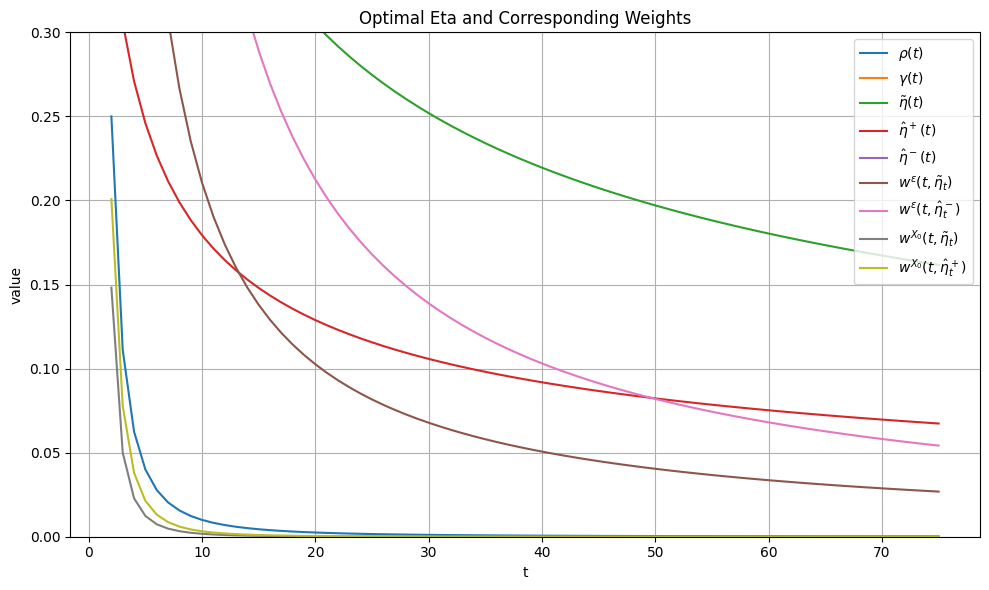

In [ ]:
T = 77
next_ind = lambda t: t+1
prev_ind = lambda t: t-1
alpha = lambda t: 1/(t+1)
sigma = lambda t: t/(t+1)

rho = lambda t: (alpha(t)/sigma(t)) ** 2
gamma = lambda t: rho(t)/rho(next_ind(t))

eta_optim = lambda t: (1-1/gamma(t)) ** 0.5
weight_optim = lambda t: gamma(t) - 1
weight_epsilon = lambda t, eta: rho(t)/eta**2 * (1/rho(t)**0.5 * (1-eta**2)**0.5- 1/rho(next_ind(t))**0.5 )**2

weight_X0 = lambda t, eta: weight_epsilon(t, eta) * rho(next_ind(t))

eta_twice_plus = lambda t: np.sqrt(1 - (
    (np.sqrt(gamma(t)) + np.sqrt(gamma(t) - (2 * gamma(t) - 1) * (2 - gamma(t)))) / (2 * gamma(t) - 1)
)**2)
eta_twice_minus = lambda t: np.sqrt(1 - (
    (np.sqrt(gamma(t)) - np.sqrt(gamma(t) - (2 * gamma(t) - 1) * (2 - gamma(t)))) / (2 * gamma(t) - 1)
)**2)



# Evaluation range
ts = np.linspace(2, T-2, T-3)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(ts, rho(ts), label=r'$\rho(t)$')
plt.plot(ts, gamma(ts), label=r'$\gamma(t)$')
plt.plot(ts, eta_optim(ts), label=r'$\tilde \eta (t)$')
plt.plot(ts, eta_twice_plus(ts), label=r'$\hat \eta^+ (t)$')
plt.plot(ts, eta_twice_minus(ts), label=r'$\hat \eta^- (t)$')
#plt.plot(ts, weight_optim(ts), label=r'$w_{\text{optim}}(t)$')
plt.plot(ts, weight_epsilon(ts, eta_optim(prev_ind(ts))), label=r'$w^\epsilon(t, \tilde \eta_{t})$')
plt.plot(ts, weight_epsilon(ts, eta_twice_minus(prev_ind(ts))), label=r'$w^\epsilon(t, \hat \eta^-_{t})$')
plt.plot(ts, weight_X0(ts, eta_optim(prev_ind(ts))), label=r'$w^{X_0}(t, \tilde \eta_{t})$')
plt.plot(ts, weight_X0(ts, eta_twice_plus(prev_ind(ts))), label=r'$w^{X_0}(t, \hat \eta^+_{t})$')
plt.xlabel('t')
plt.ylabel('value')
plt.title('Optimal Eta and Corresponding Weights')
plt.ylim(0, 0.3)  # restrict y-axis range
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()